# Lab 6
Team: <br></br>
Mitchell Morrison <br></br>
Kyle Kolodziej <br></br>
Brian Pattison <br></br>
Sam Yassien <br></br>

## Overview of Data Set
Our dataset from AffectNet (http://mohammadmahoor.com/affectnet/, which can also be found with the PDF uploaded in this directory) is intended to be used for image emotion prediction. The dataset contains 291,651 images. The data set has 8 different image labels: Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, and Contempt. Our data set is imbalanced with some of the labels having a lot more images than other labels. For example, there are 134,915 images that are classified as Happy while there are only 4,250 images that are classified as Contempt. 

## Business Case and Measurement of Performance
Looking at out business case, we believe a model to predict the emotion from an image would be uesful as a program for Autistic children. This program would help them develop in identifying people's emotions. However, there are a lot of different image labels that may be hard to distinguish between. With this is mind, we believe it would be beneficial to just look at classifying images that are Neutral, Happy, Sad, and Angry. We picked these 4 categories as we feel that these 4 emotions would be very useful for a user that our business case is geared towards. Also, we believe that it would be better to have a model that has a higher accuracy with predicting a smaller amount of labels rather than a lower accuracy and predicting all of the labels. We believe that a child using this program would not find the model as useful if they are getting a low accuracy in classifying images and, thus, would not be able to correctly gauge another person's emotions.

We will use accuracy to measure the performance of our model. A typical user would be equally as interested in predicting all 4 of the classes that we are using as emotions to predict. Thus, accuracy serves as a good measurement tool for our model.

Source: https://www.nature.com/articles/s41598-019-52211-8

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import os
import glob
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image 
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [5]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test, first, sec, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(first + " : " + str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(sec + " : " + str(acc_mlp))

Below, we are getting the images from the data set. Can set the number of images that the model will get or just comment out and let it grab all the images

In [8]:
def getAndResizeImages(file_path) :
    gray = []
    color = []
    imageNumber = []
    for file in os.listdir(file_path) :
        path = file_path + '/' + file
        fileNum = file.replace('.jpg', '')
        im = Image.open(path)
        im = im.resize((50, 50))
        color.append(np.array(im))
        im = im.convert("L")
        gray.append(np.array(im))
        imageNumber.append(str(fileNum))
        if len(gray) > 50000:
            break
    return gray, color, imageNumber


folderPathImage = "../../train_set/train_set/images"
resizedImages, colored, imageNum = getAndResizeImages(folderPathImage)


In [411]:
print(len(resizedImages), "total images")

50001 total images


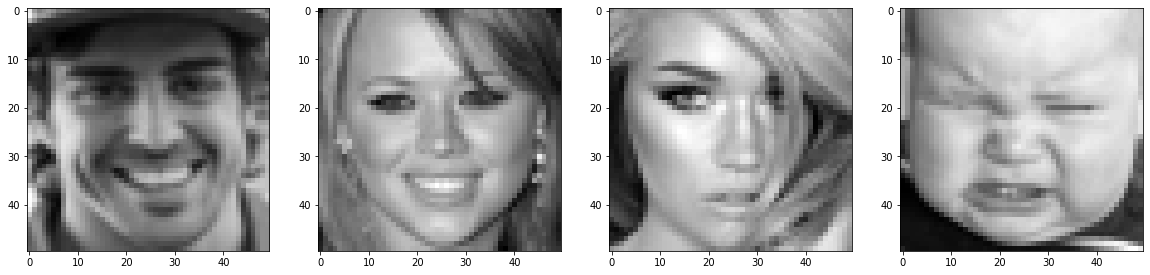

In [412]:
# Let's look at 4 of the images
plt.figure(figsize=(20,20))
for i in range(4):
    img=resizedImages[i]
    ax=plt.subplot(1,4,i+1)
    plt.imshow(img,cmap="gray")

In [10]:
# Going to grab the image labels that correspond to the image
def getImageLabel(file_path,imageNum) :
    labels = []
    for num in imageNum:
        path = file_path + num + "_exp.npy"
        data = np.load(path)
        labels.append(float(data))
    print(len(labels))
    return labels

folderPathAnnotation = "../../train_set/train_set/annotations/"

labels = getImageLabel(folderPathAnnotation, imageNum)

50001


In [414]:
pd.unique(labels)

array([1., 0., 6., 2., 4., 3., 5., 7.])

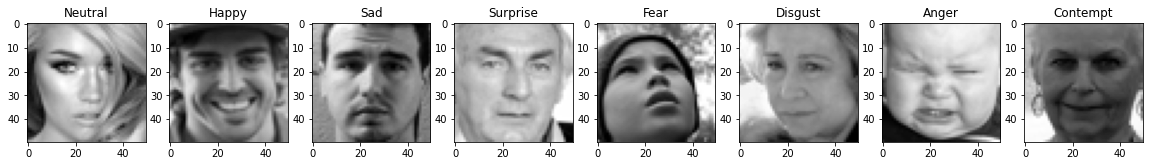

In [415]:
# Print out an image from each type
types = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
plt.figure(figsize=(20,20))
for i in range(8):
    index = labels.index(i)
    img=resizedImages[index]
    ax=plt.subplot(1,8,i+1)
    plt.title(types[i])
    plt.imshow(img,cmap="gray")

In [417]:
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    plt.figure(figsize=(15,7))
    plt.imshow(resizedImages[idx_to_reconstruct],cmap="gray")
    plt.title(types[int(labels[idx_to_reconstruct])])
    plt.grid(False)
    
    
n_samples = len(labels)   
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

interactive(children=(IntSlider(value=25000, description='idx_to_reconstruct', max=50000), Output()), _dom_cla…

<function __main__.plt_reconstruct(idx_to_reconstruct)>

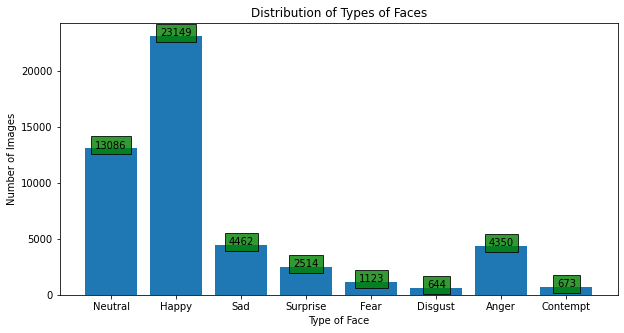

In [418]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = 'center',
                 Bbox = dict(facecolor = 'green', alpha =.8))
y_pos = np.arange(len(types))
labelCount = []
plt.figure(figsize=(10,5))
for i in range(8):
    #print("Count of " + types[i] + ": " , labels.count(i))
    labelCount.append(labels.count(i))
plt.bar(types, labelCount)
addlabels(types, labelCount)
plt.title("Distribution of Types of Faces")
plt.xlabel('Type of Face')
plt.ylabel('Number of Images')
plt.show()

In [11]:
# Will now reduce the labels down to just Neutral, Happy, Sad, and Angry
def createDataset(labels, resizedImages):
    reducedImgs = []
    reducedLabels = []
    labelQuantities = [0, 0, 0, 0]
    for label, img in zip(labels,resizedImages) :
        if label == 0 and labelQuantities[0] < 4000:
                reducedImgs.append(img)
                reducedLabels.append(int(label))
                labelQuantities[0] = labelQuantities[0] + 1
        if label == 1 and labelQuantities[1] < 4000:
                reducedImgs.append(img)
                reducedLabels.append(int(label))
                labelQuantities[1] = labelQuantities[1] + 1
        if label == 2 and labelQuantities[2] < 4000:
                reducedImgs.append(img)
                reducedLabels.append(int(label))
                labelQuantities[2] = labelQuantities[2] + 1
        if label == 6 and labelQuantities[3] < 4000:
                reducedImgs.append(img)
                reducedLabels.append(int(3))
                labelQuantities[3] = labelQuantities[3] + 1
    return reducedImgs, reducedLabels, labelQuantities
reducedImgs, reducedLabels, labelQuantities = createDataset(labels, resizedImages)
reducedImgsColor, reducedLabels, labelQuantities = createDataset(labels, colored)

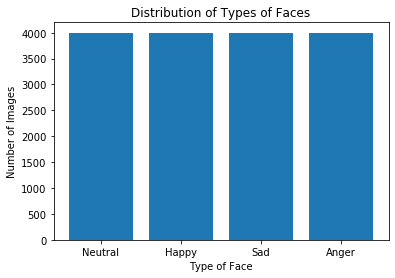

In [40]:
newTypes = ['Neutral', 'Happy', 'Sad', 'Anger']
plt.bar(newTypes, labelQuantities)
plt.title("Distribution of Types of Faces")
plt.xlabel('Type of Face')
plt.ylabel('Number of Images')
plt.show()

## Train/Test Split

We are going to use a Stratified Shuffle Split with the number of splits as 1 and the test size as 0.2. We want to keep the training and testing sets balanced, so we are using the stratified shuffle split. We decided we only need 1 split and a training/test split of 80/20.

One approach that we thought would be smart is to use all the image data, keep the number of splits as 1, and reduce the test size to 0.1. This would keep the training and testing sets balanced. Also, since there is so much data (we would be working on a data set of 100k images with using 25k images for each class), we would only need a 90/10 training and testing split . Following this split, we would have a training set of 90k images and a testing set of 10k images. Thus, our model would be used on training with 22.5k images per class and predicting 2.5k images per each class. Unfortunately, using this many images took too long, so we decided to go with the 80/20 split on a total of 4k images as described above.

In [13]:
from sklearn.preprocessing import StandardScaler
def preparingData(reducedLabels, reducedImgs, colored=False):
    y = np.array(reducedLabels)
    X = np.array(reducedImgs)
    if not colored:
        num_channels = 1
    else:
        num_channels = 3
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    sss.get_n_splits(X, y)
    scaler = StandardScaler()
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        num_instances = X_train.shape[0]
        X_train = np.reshape(X_train, (-1, num_instances))
    #     X_train = scaler.fit_transform(X_train)
        X_train = (X_train / 255) - .5
        X_train = X_train.reshape(num_instances,50,50,num_channels)
    #     print(“SCALED X-TRAIN”, X_train)
        num_instances = X_test.shape[0]
        X_test = np.reshape(X_test, (-1, num_instances))
    #     X_test = scaler.fit_transform(X_test)
        X_test = (X_test / 255) - .5
        X_test = X_test.reshape(num_instances,50,50,num_channels)
    #     print(“SCALED X_test”, X_test)
        y_train, y_test = y[train_index], y[test_index]
    return (X_train, X_test), (y_train, y_test)
(X_train, X_test), (y_train, y_test) = preparingData(reducedLabels, reducedImgs)
(X_train_color, X_test_color), (y_train_color, y_test_color) = preparingData(reducedLabels, reducedImgsColor, colored=True)

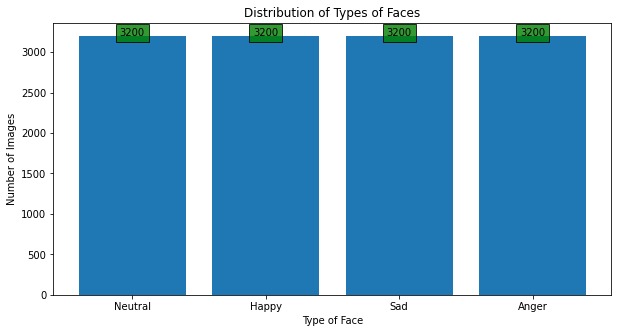

In [423]:
#Printing out the training set
labelCount = []
plt.figure(figsize=(10,5))
for i in range(4):
    #print("Count of " + types[i] + ": " , labels.count(i))
    labelCount.append((y_train == i).sum())
plt.bar(newTypes, labelCount)
addlabels(newTypes, labelCount)
plt.title("Distribution of Types of Faces")
plt.xlabel('Type of Face')
plt.ylabel('Number of Images')
plt.show()

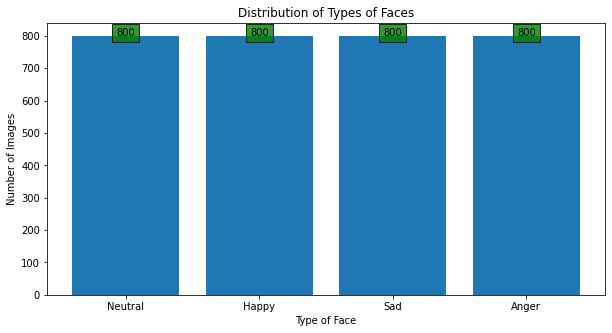

In [424]:
#Printing out the testing set
labelCount = []
plt.figure(figsize=(10,5))
for i in range(4):
    #print("Count of " + types[i] + ": " , labels.count(i))
    labelCount.append((y_test == i).sum())
plt.bar(newTypes, labelCount)
addlabels(newTypes, labelCount)
plt.title("Distribution of Types of Faces")
plt.xlabel('Type of Face')
plt.ylabel('Number of Images')
plt.show()

In [14]:
NUM_CLASSES = 4

# make one- hot encoded versions of the data
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

## Running a MLP and base line CNN on the Data Set

In [ ]:
%%time

# make a keras MLP
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=50, 
        shuffle=True, verbose=1, validation_data = (X_test,y_test_ohe),
       callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/15
400/400 [==============================] - 24s 61ms/step - loss: 0.1643 - accuracy: 0.4405 - val_loss: 0.1472 - val_accuracy: 0.5256
Epoch 2/15
400/400 [==============================] - 27s 66ms/step - loss: 0.1435 - accuracy: 0.5447 - val_loss: 0.1485 - val_accuracy: 0.5209
Epoch 3/15
400/400 [==============================] - 24s 60ms/step - loss: 0.1338 - accuracy: 0.5822 - val_loss: 0.1403 - val_accuracy: 0.5537
Epoch 4/15
400/400 [==============================] - 23s 58ms/step - loss: 0.1251 - accuracy: 0.6177 - val_loss: 0.1408 - val_accuracy: 0.5547
Epoch 5/15
400/400 [==============================] - 27s 67ms/step - loss: 0.1158 - accuracy: 0.6512 - val_loss: 0.1355 - val_accuracy: 0.5809
Epoch 6/15
400/400 [==============================] - 25s 61ms/step - loss: 0.1058 - accuracy: 0.6889 - val_loss: 0.1457 - val_accuracy: 0.5537
Epoch 7/15
400/400 [==============================] - 26s 66ms/step - loss: 0.0946 - accuracy: 0.7291 - val_loss: 0.1446 - val_accuracy:

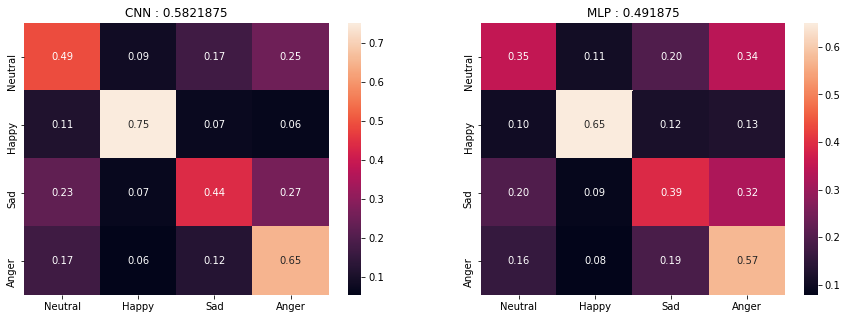

In [427]:
%%time

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',data_format="channels_last") )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                           data_format="channels_last") )
    

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn1.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1,validation_data=(X_test,y_test_ohe),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

compare_mlp_cnn(cnn1,mlp,X_test,y_test,'CNN', 'MLP', newTypes)

## Data Expansion Technique - Image Data Generator

We are using the ImageDataGenerator to make sure our models do not overfit to the data used in training. We do this by rotating our image a various degree at each iteration and by allowing small random position shifts and horizontal flips. Each of these make sense to use of our image as well to improve trainingOther techniques do not make as much sense because our images in a test set would likely resemble the sorts of manipulations we have shown here. because real world images people may have their head tilted or the angle may be adjusted in the picture. 

In [428]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from skimage.io import imshow
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

idx = 0

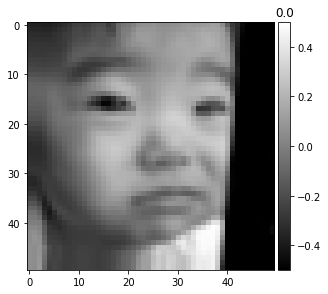

In [429]:
from skimage.io import imshow
tmps = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='gray')
    plt.title(labels[np.argmax(tmp[1])])
    break

In [31]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])
    
    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])


    plt.show()


In [431]:
%%time 

img_wh = 50
cnn1 = Sequential()

# let's start with an AlexNet style convolutional phase
cnn1.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn1.add(Flatten())
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn1.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
history1 = cnn1.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                   steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                   epochs=50, verbose=1,
                   validation_data=(X_test,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                  )
cnn1.save('cnn1_model')



Epoch 1/50
400/400 [==============================] - 103s 257ms/step - loss: 1.3620 - accuracy: 0.3305 - val_loss: 1.2016 - val_accuracy: 0.4556
Epoch 2/50
400/400 [==============================] - 99s 247ms/step - loss: 1.2531 - accuracy: 0.4195 - val_loss: 1.1249 - val_accuracy: 0.5050
Epoch 3/50
400/400 [==============================] - 119s 298ms/step - loss: 1.2061 - accuracy: 0.4496 - val_loss: 1.0597 - val_accuracy: 0.5306
Epoch 4/50
400/400 [==============================] - 95s 238ms/step - loss: 1.1670 - accuracy: 0.4748 - val_loss: 1.0268 - val_accuracy: 0.5472
Epoch 5/50
400/400 [==============================] - 70s 175ms/step - loss: 1.1513 - accuracy: 0.4822 - val_loss: 1.0276 - val_accuracy: 0.5419
Epoch 6/50
400/400 [==============================] - 59s 147ms/step - loss: 1.1425 - accuracy: 0.4811 - val_loss: 1.0158 - val_accuracy: 0.5553
Epoch 7/50
400/400 [==============================] - 58s 144ms/step - loss: 1.1265 - accuracy: 0.5008 - val_loss: 1.0104 - val_

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: cnn1_model/assets


INFO:tensorflow:Assets written to: cnn1_model/assets


CPU times: user 50min 55s, sys: 15min 31s, total: 1h 6min 26s
Wall time: 15min 1s


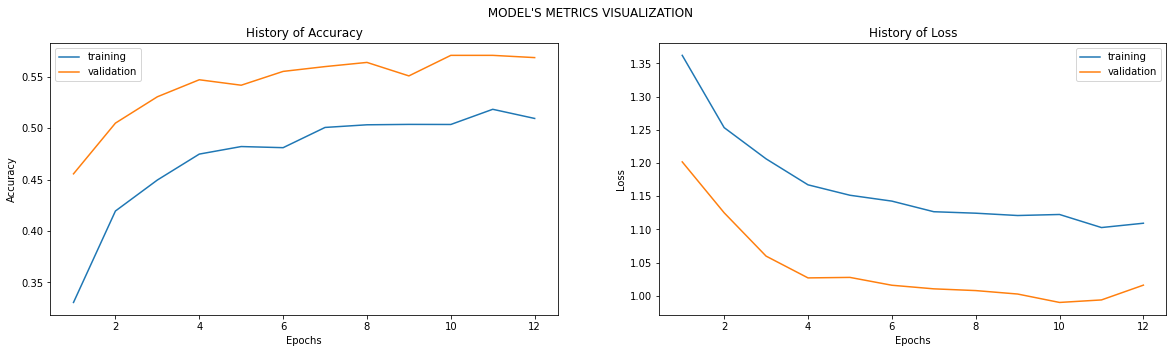

In [432]:
Train_Val_Plot(history1.history['accuracy'],history1.history['val_accuracy'],
               history1.history['loss'],history1.history['val_loss'],
              )


From this plot we can see loss bottom out at ~ 1.

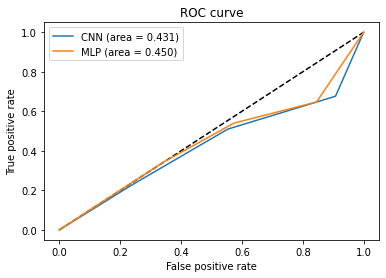

In [433]:
yhat_cnn = np.argmax(cnn1.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [435]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.705072  0.294928
True   0.358791  0.641209
statistic=0.858, p-value=0.4
Same proportions of errors (don't reject H0)


Changed the model above in the cell block below. The first max pool now is a 3x3. Following this max pool, we send this through another convolutional layer and max pool (although this is just a 2x2 max pool). Additionally, we increased the batch size from 32 to 64 along with adding in the l2 regularization

In [439]:
from tensorflow.keras.regularizers import l2 
l2_lambda = 0.0001

img_wh = 50
cnn2 = Sequential()

# let's start with an AlexNet style convolutional phase
cnn2.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

cnn2.add(Conv2D(filters=64,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu')) # more compact syntax
cnn2.add(MaxPooling2D(pool_size=(3, 3), data_format="channels_last"))

cnn2.add(Conv2D(filters=128,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu')) # more compact syntax
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn2.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
history2 = cnn2.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=64), 
                   steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                   epochs=50, verbose=1,
                   validation_data=(X_test,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                  )
cnn2.save('cnn2_model')



Epoch 1/50
200/200 [==============================] - 54s 268ms/step - loss: 1.4664 - accuracy: 0.3258 - val_loss: 1.2848 - val_accuracy: 0.4181
Epoch 2/50
200/200 [==============================] - 52s 259ms/step - loss: 1.2831 - accuracy: 0.4215 - val_loss: 1.1134 - val_accuracy: 0.5116
Epoch 3/50
200/200 [==============================] - 50s 249ms/step - loss: 1.1971 - accuracy: 0.4717 - val_loss: 1.1033 - val_accuracy: 0.5322
Epoch 4/50
200/200 [==============================] - 51s 254ms/step - loss: 1.1366 - accuracy: 0.5016 - val_loss: 1.0867 - val_accuracy: 0.5266
Epoch 5/50
200/200 [==============================] - 49s 247ms/step - loss: 1.0978 - accuracy: 0.5225 - val_loss: 0.9778 - val_accuracy: 0.5916
Epoch 6/50
200/200 [==============================] - 50s 249ms/step - loss: 1.0664 - accuracy: 0.5398 - val_loss: 0.9585 - val_accuracy: 0.5975
Epoch 7/50
200/200 [==============================] - 50s 250ms/step - loss: 1.0497 - accuracy: 0.5537 - val_loss: 0.9505 - val_ac

INFO:tensorflow:Assets written to: cnn2_model/assets


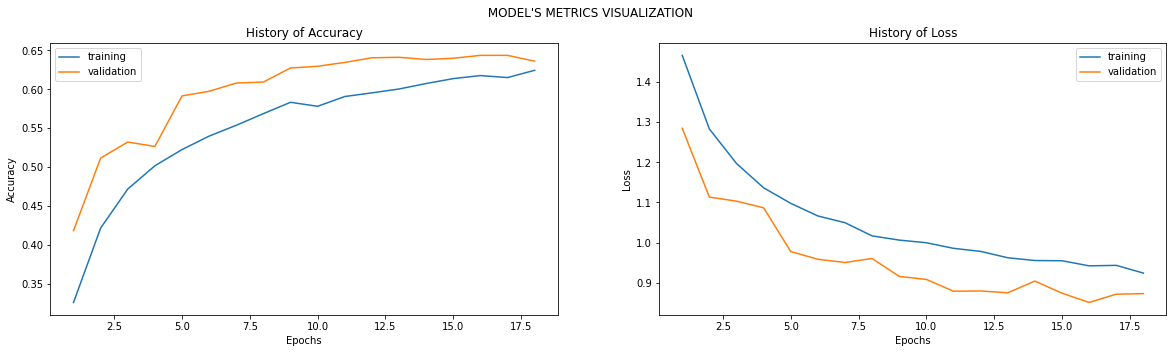

In [441]:
Train_Val_Plot(history2.history['accuracy'],history2.history['val_accuracy'],
               history2.history['loss'],history2.history['val_loss']
              )

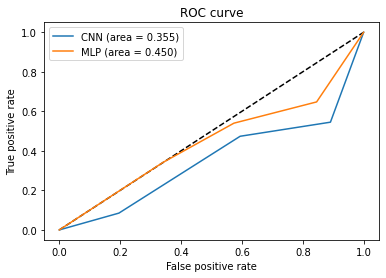

In [442]:
yhat_cnn = np.argmax(cnn2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [443]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.695017  0.304983
True   0.401277  0.598723
statistic=1.007, p-value=0.3
Same proportions of errors (don't reject H0)


Now let's compare the first cnn to this new cnn below

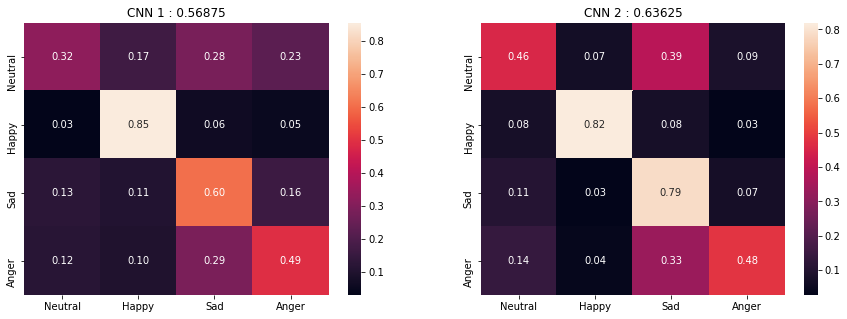

In [445]:
compare_mlp_cnn(cnn1,cnn2,X_test,y_test,'CNN 1', 'CNN 2',newTypes)

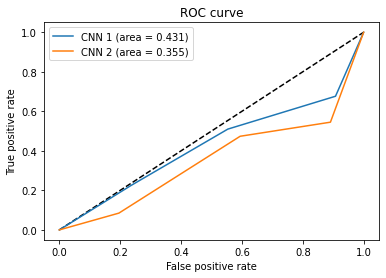

In [446]:
yhat_cnn = np.argmax(cnn1.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(cnn2.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN 1 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='CNN 2 (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [447]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.645652  0.354348
True   0.150000  0.850000
statistic=0.531, p-value=0.5
Same proportions of errors (don't reject H0)


Now change the max pools to 2x2, add in another convolutional layer, back to 32 batch size, and taking away some of the dropout

In [449]:
from tensorflow.keras.regularizers import l2
l2_lambda = 0.0001
cnn4 = Sequential()
cnn4.add( Conv2D(filters=32,
                kernel_size= (3, 3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                input_shape=(img_wh, img_wh, 1),
                activation='relu',
                data_format="channels_last") )
# cnn.add( MaxPooling2D(pool_size=(2, 2),
#                 data_format="channels_last") )
cnn4.add( Conv2D(filters=32,
                kernel_size= (3, 3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                input_shape=(img_wh, img_wh, 1),
                activation='relu',
                data_format="channels_last") )
cnn4.add( MaxPooling2D(pool_size=(2, 2),
                data_format="channels_last") )
cnn4.add( Conv2D(filters=64,
                kernel_size= (3, 3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                input_shape=(img_wh, img_wh, 1),
                activation='relu',
                data_format="channels_last") )
# cnn.add( MaxPooling2D(pool_size=(2, 2),
#                 data_format="channels_last") )
cnn4.add( Conv2D(filters=64,
                kernel_size= (3, 3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                input_shape=(img_wh, img_wh, 1),
                activation='relu',
                data_format="channels_last") )
cnn4.add( MaxPooling2D(pool_size=(2, 2),
                data_format="channels_last") )
cnn4.add(Conv2D(filters=128,
               input_shape=(img_wh, img_wh, 1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform',
               kernel_regularizer=l2(l2_lambda),
               padding='same',
               activation='relu',data_format="channels_last")) # more compact syntax
cnn4.add(Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform',
               kernel_regularizer=l2(l2_lambda),
               padding='same',
               activation='relu',data_format="channels_last"))
# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add(Dropout(0.25))
cnn4.add(Dense(128,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda) ))
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )

cnn4.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])
# the flow method yields batches of images indefinitely, with the given transformations
history_cnn4 = cnn4.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32),
                   steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                   epochs=50, verbose=1,
                   validation_data=(X_test,y_test_ohe),
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])

cnn4.save('cnn4_model')


Epoch 1/50
400/400 [==============================] - 92s 229ms/step - loss: 1.3982 - accuracy: 0.3916 - val_loss: 1.1561 - val_accuracy: 0.4819
Epoch 2/50
400/400 [==============================] - 82s 205ms/step - loss: 1.1253 - accuracy: 0.5198 - val_loss: 1.0131 - val_accuracy: 0.5728
Epoch 3/50
400/400 [==============================] - 82s 205ms/step - loss: 1.0518 - accuracy: 0.5627 - val_loss: 1.0421 - val_accuracy: 0.5878
Epoch 4/50
400/400 [==============================] - 82s 204ms/step - loss: 1.0175 - accuracy: 0.5876 - val_loss: 0.9666 - val_accuracy: 0.6059
Epoch 5/50
400/400 [==============================] - 82s 206ms/step - loss: 0.9806 - accuracy: 0.6072 - val_loss: 0.9319 - val_accuracy: 0.6297
Epoch 6/50
400/400 [==============================] - 82s 205ms/step - loss: 0.9632 - accuracy: 0.6122 - val_loss: 0.9313 - val_accuracy: 0.6400
Epoch 7/50
400/400 [==============================] - 82s 205ms/step - loss: 0.9426 - accuracy: 0.6297 - val_loss: 0.9465 - val_ac

INFO:tensorflow:Assets written to: cnn4_model/assets


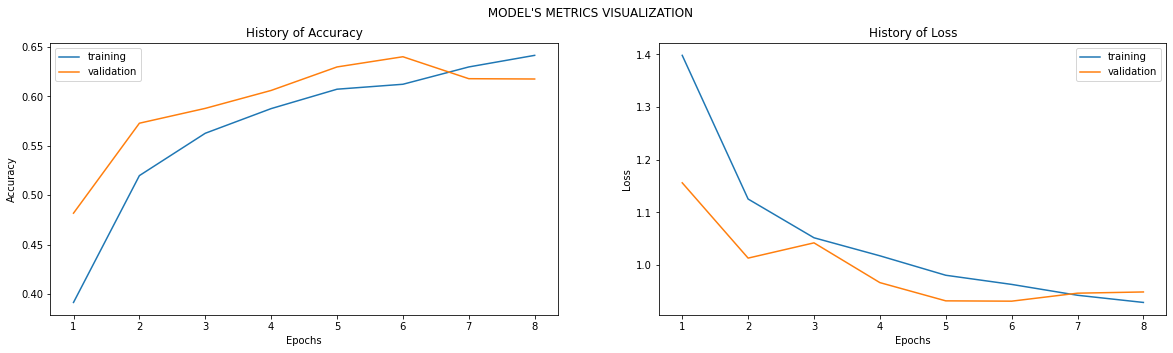

In [450]:
Train_Val_Plot(history_cnn4.history['accuracy'],history_cnn4.history['val_accuracy'],
               history_cnn4.history['loss'],history_cnn4.history['val_loss'],
              )

## Compare to MLP

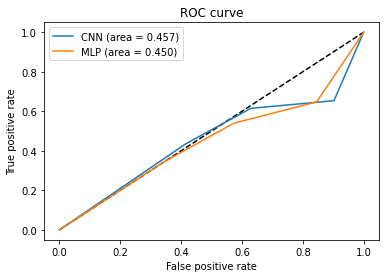

In [451]:
yhat_cnn = np.argmax(cnn4.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [452]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.714869  0.285131
True   0.380061  0.619939
statistic=0.893, p-value=0.3
Same proportions of errors (don't reject H0)


Compare this one to the previous best CNN of similar architecture

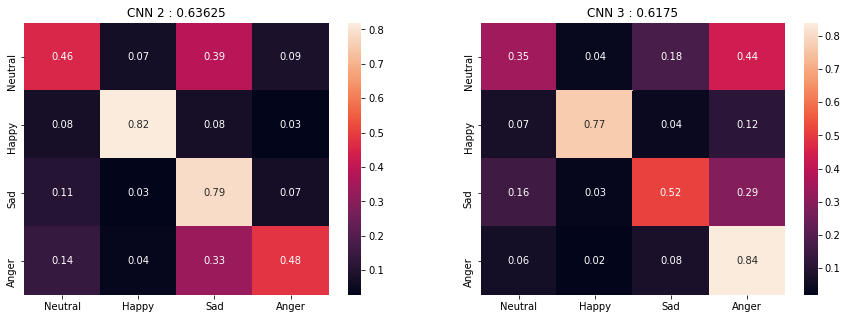

In [454]:
compare_mlp_cnn(cnn2,cnn4,X_test,y_test,'CNN 2', 'CNN 3', newTypes)

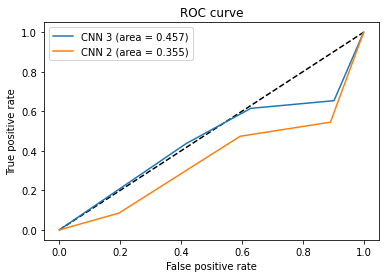

In [455]:
yhat_cnn = np.argmax(cnn4.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(cnn2.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN 3 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='CNN 2 (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [456]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.608660  0.391340
True   0.212045  0.787955
statistic=0.752, p-value=0.4
Same proportions of errors (don't reject H0)


Now let's use Xception model

In [458]:
# Xception style architecture
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

l2_lambda = 0.000001



input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)
xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

historyXcept = xception.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                      steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                     )
xception.save('xception_model')


Epoch 1/50
400/400 [==============================] - 22s 55ms/step - loss: 1.3481 - accuracy: 0.3415 - val_loss: 1.2146 - val_accuracy: 0.4453
Epoch 2/50
400/400 [==============================] - 22s 56ms/step - loss: 1.2416 - accuracy: 0.4278 - val_loss: 1.0967 - val_accuracy: 0.5147
Epoch 3/50
400/400 [==============================] - 22s 55ms/step - loss: 1.1877 - accuracy: 0.4596 - val_loss: 1.0478 - val_accuracy: 0.5353
Epoch 4/50
400/400 [==============================] - 22s 55ms/step - loss: 1.1470 - accuracy: 0.4895 - val_loss: 1.0488 - val_accuracy: 0.5181
Epoch 5/50
400/400 [==============================] - 23s 57ms/step - loss: 1.1015 - accuracy: 0.5091 - val_loss: 0.9959 - val_accuracy: 0.5738
Epoch 6/50
400/400 [==============================] - 22s 55ms/step - loss: 1.0744 - accuracy: 0.5284 - val_loss: 0.9699 - val_accuracy: 0.5750
Epoch 7/50
400/400 [==============================] - 22s 55ms/step - loss: 1.0506 - accuracy: 0.5352 - val_loss: 0.9900 - val_accuracy:

INFO:tensorflow:Assets written to: xception_model/assets


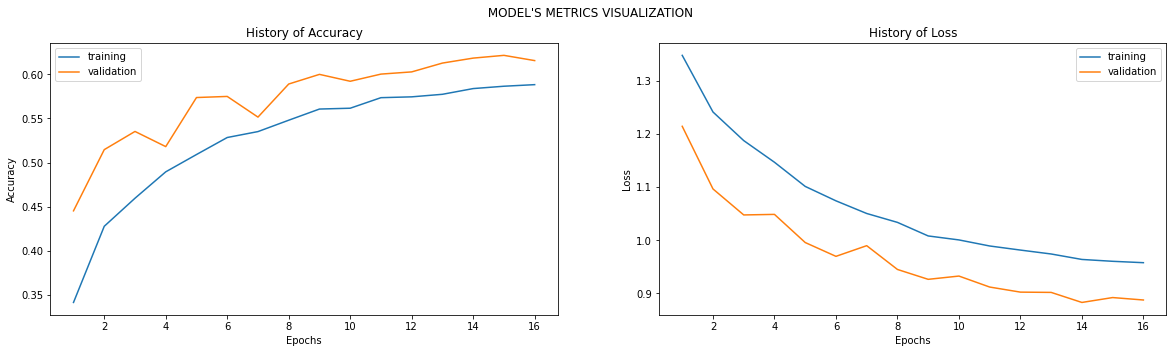

In [459]:
Train_Val_Plot(historyXcept.history['accuracy'],historyXcept.history['val_accuracy'],
               historyXcept.history['loss'],historyXcept.history['val_loss'],
              )

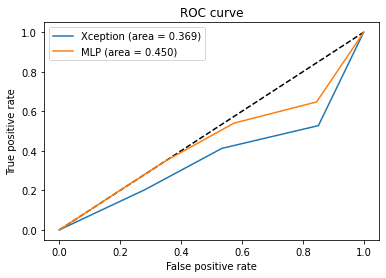

In [460]:
yhat_cnn = np.argmax(xception.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [461]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.721951  0.278049
True   0.374619  0.625381
statistic=0.860, p-value=0.4
Same proportions of errors (don't reject H0)


Switching some stuff up from the Xception model above. Added in 3 convolutional layers, a max pooling, and batch size up to 64. Additionally, decreased the dropout in both dropout percentages by 20%

In [463]:
# Xception style architecture
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

l2_lambda = 0.000001



input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

#Changes

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)
x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)
x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception2 = Model(inputs=input_holder,outputs=x)
xception2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

historyXcept2 = xception2.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=64), 
                      steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                     )

xception2.save('xception2_model')

Epoch 1/50
200/200 [==============================] - 21s 105ms/step - loss: 1.3541 - accuracy: 0.3267 - val_loss: 1.2374 - val_accuracy: 0.4503
Epoch 2/50
200/200 [==============================] - 20s 101ms/step - loss: 1.2097 - accuracy: 0.4455 - val_loss: 1.1284 - val_accuracy: 0.4681
Epoch 3/50
200/200 [==============================] - 20s 101ms/step - loss: 1.1187 - accuracy: 0.4945 - val_loss: 1.0366 - val_accuracy: 0.5444
Epoch 4/50
200/200 [==============================] - 21s 103ms/step - loss: 1.0748 - accuracy: 0.5213 - val_loss: 0.9886 - val_accuracy: 0.5641
Epoch 5/50
200/200 [==============================] - 20s 102ms/step - loss: 1.0422 - accuracy: 0.5372 - val_loss: 0.9721 - val_accuracy: 0.5738
Epoch 6/50
200/200 [==============================] - 20s 101ms/step - loss: 1.0173 - accuracy: 0.5459 - val_loss: 0.9615 - val_accuracy: 0.5834
Epoch 7/50
200/200 [==============================] - 21s 105ms/step - loss: 0.9924 - accuracy: 0.5637 - val_loss: 0.9502 - val_ac

INFO:tensorflow:Assets written to: xception2_model/assets


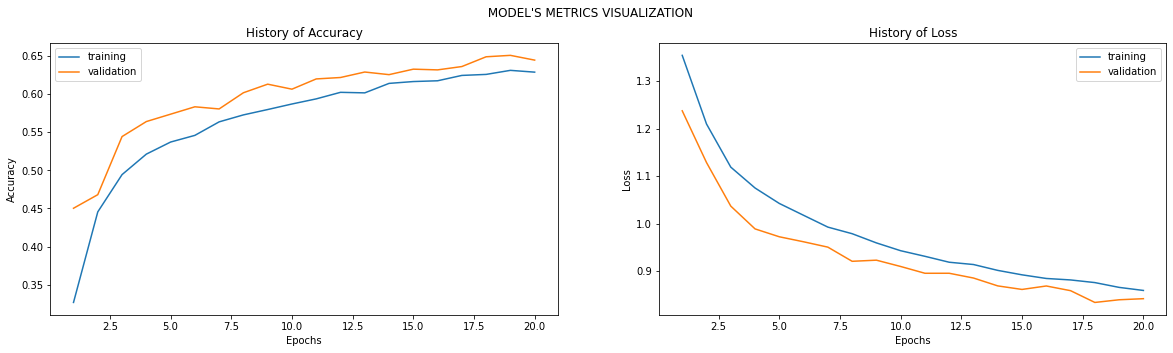

In [464]:
Train_Val_Plot(historyXcept2.history['accuracy'],historyXcept2.history['val_accuracy'],
               historyXcept2.history['loss'],historyXcept2.history['val_loss'],
              )

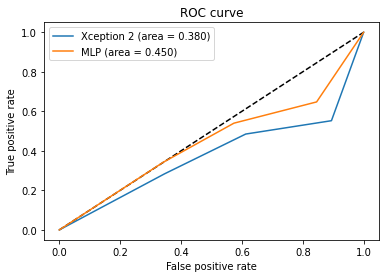

In [465]:
yhat_cnn = np.argmax(xception2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception 2 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [466]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.737027  0.262973
True   0.381968  0.618032
statistic=0.844, p-value=0.4
Same proportions of errors (don't reject H0)


Now, let's compare the 2 Xception models to each other

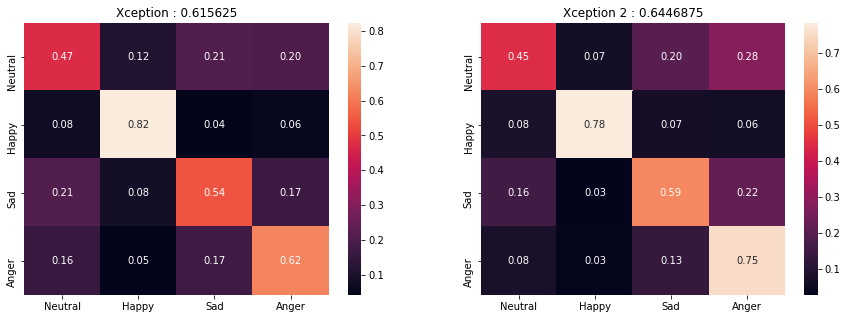

In [468]:
compare_mlp_cnn(xception,xception2,X_test,y_test,'Xception', 'Xception 2', newTypes)

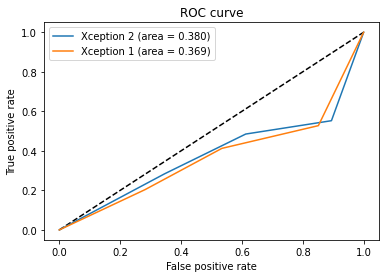

In [469]:
yhat_cnn = np.argmax(xception2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(xception.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception 2 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='Xception 1 (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [470]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.723835  0.276165
True   0.197286  0.802714
statistic=0.451, p-value=0.5
Same proportions of errors (don't reject H0)


In [471]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

statistic=65.000, p-value=0.0
Different proportions of errors (reject H0)


Now, let's compare the best Xception model to the best model of the first CNN styled architecture

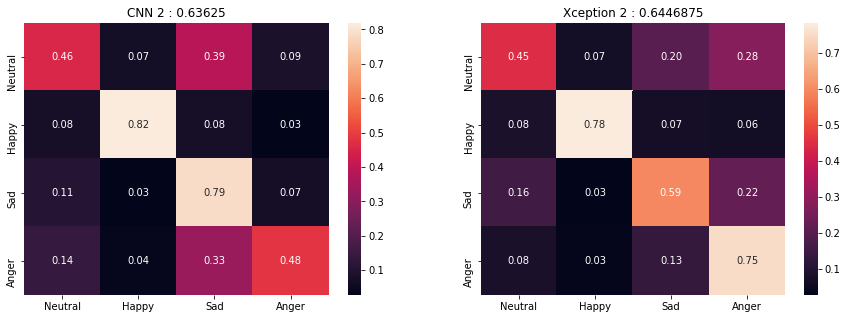

In [525]:
compare_mlp_cnn(cnn2,xception2,X_test,y_test,'CNN 2', 'Xception 2',newTypes)

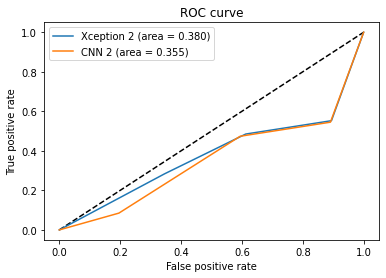

In [526]:
yhat_cnn = np.argmax(xception2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(cnn2.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception 2 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='CNN 2 (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


## Best Models
From all of the models, run, we can see our CNN2 and XceptionNet2 have performed the best reaching 63 and 64 % accuracy, respectively. 

## Ensemble Net - Attempted, but didn't work

Attempted to use ensemble net, but we were getting 25% val accuracy every epoch and couldn't figure out why it didn't change at all

In [474]:
## Ensemble Net

from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)
#ADD MAX POOL LAYER HERE
x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)


In [475]:
# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])



In [476]:
%%time
# the flow method yields batches of images indefinitely, with the given transofmrations
history3 = cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                      steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                     )

Epoch 1/50
400/400 [==============================] - 75s 187ms/step - loss: 1.3906 - accuracy: 0.2441 - val_loss: 1.3880 - val_accuracy: 0.2500
Epoch 2/50
400/400 [==============================] - 72s 180ms/step - loss: 1.3881 - accuracy: 0.2486 - val_loss: 1.3880 - val_accuracy: 0.2500
Epoch 3/50
400/400 [==============================] - 72s 180ms/step - loss: 1.3881 - accuracy: 0.2390 - val_loss: 1.3880 - val_accuracy: 0.2500
Epoch 4/50
400/400 [==============================] - 72s 181ms/step - loss: 1.3881 - accuracy: 0.2470 - val_loss: 1.3879 - val_accuracy: 0.2500
Epoch 5/50
400/400 [==============================] - 75s 187ms/step - loss: 1.3880 - accuracy: 0.2429 - val_loss: 1.3879 - val_accuracy: 0.2500
Epoch 6/50
400/400 [==============================] - 66s 164ms/step - loss: 1.3880 - accuracy: 0.2444 - val_loss: 1.3879 - val_accuracy: 0.2500
Epoch 7/50
400/400 [==============================] - 62s 154ms/step - loss: 1.3880 - accuracy: 0.2459 - val_loss: 1.3879 - val_ac

Changing the Ensemble Net. After concatenating the branches, going to add some drop out and a dense layer before sending it throught the final dense layer. Also, increased the number of branches from 3 to 4

In [478]:
from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model

num_ensembles = 4
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)
#ADD MAX POOL LAYER HERE
x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

#Changes Here

x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
x = Dense(64, 
            activation='relu',
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda)
            )(x)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens2 = Model(inputs=input_holder,outputs=x)


In [479]:
# Let's train the model 
cnn_ens2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])



In [480]:
%%time
# the flow method yields batches of images indefinitely, with the given transofmrations
history4 = cnn_ens2.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                      steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                     )

Epoch 1/50
400/400 [==============================] - 91s 227ms/step - loss: 1.3922 - accuracy: 0.2491 - val_loss: 1.3887 - val_accuracy: 0.2500
Epoch 2/50
400/400 [==============================] - 119s 298ms/step - loss: 1.3888 - accuracy: 0.2459 - val_loss: 1.3886 - val_accuracy: 0.2500
Epoch 3/50
400/400 [==============================] - 126s 316ms/step - loss: 1.3887 - accuracy: 0.2459 - val_loss: 1.3886 - val_accuracy: 0.2500
Epoch 4/50
400/400 [==============================] - 148s 370ms/step - loss: 1.3887 - accuracy: 0.2491 - val_loss: 1.3886 - val_accuracy: 0.2500
Epoch 5/50
400/400 [==============================] - 150s 375ms/step - loss: 1.3887 - accuracy: 0.2446 - val_loss: 1.3885 - val_accuracy: 0.2500
Epoch 6/50
371/400 [==========================>...] - ETA: 10s - loss: 1.3887 - accuracy: 0.2445

KeyboardInterrupt: 

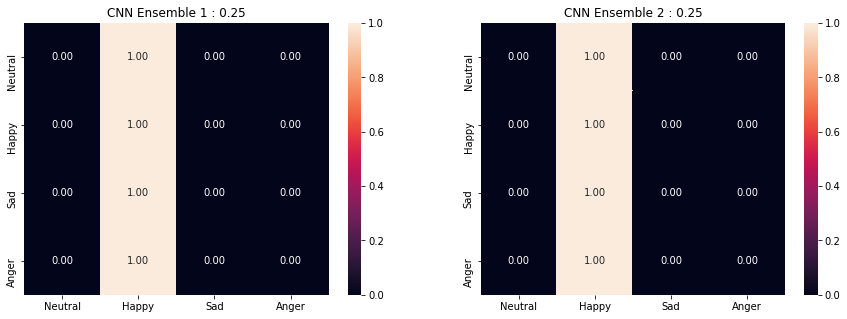

In [483]:
compare_mlp_cnn(cnn_ens,cnn_ens2,X_test,y_test, 'CNN Ensemble 1', 'CNN Ensemble 2', newTypes)


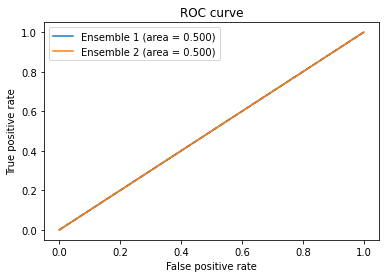

In [523]:
yhat_cnn = np.argmax(cnn_ens.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(cnn_ens2.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Ensemble 1 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='Ensemble 2 (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

In [499]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0  False  True 
row_0              
False    1.0    0.0
True     0.0    1.0
statistic=0.000, p-value=1.0
Same proportions of errors (don't reject H0)


We can see that since the ensemble nets did not properly train the chi sq test does not reject the null hypothesis that H0 is not statistically different from H1. The other cases where the Chi sq test does not reject the null hypothesis are using credible results from training and prediction.


It also seems that all of our ROC curves are performing poorly below .5. This could be an indication of poor labeling or a bad training algorithm.

## Exceptional Work

Transfer Learning with ResNet50!!

First, we ohe our y data. <br></br>
Second, we get the resnet50 base model that will serve as a majority of our NN.<br></br>
Third, we preprocess the input and use the base modelto run a .predict on the image data.<br></br>
Then, we create our model with the desired layers and fit the model to the preprocessed data.


In [ ]:
y_train_ohe_c = keras.utils.to_categorical(y_train_color, NUM_CLASSES)
y_test_ohe_c = keras.utils.to_categorical(y_test_color, NUM_CLASSES)

## Exceptional Work II

In [15]:
import tensorflow as tf
import keras
from keras.layers.normalization import BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model

In [16]:
y_train_ohe_c = keras.utils.to_categorical(y_train_color, NUM_CLASSES)
y_test_ohe_c = keras.utils.to_categorical(y_test_color, NUM_CLASSES)

In [17]:
%%time
# from skimage.transform import resize # stupid slow function
#from scipy.misc import imresize
import numpy as np

# CIFAR is really small, so let's increase the size of it so its not so small
# once we put it through all the downsampling layers
#x_train_up = [imresize(x, size=(64,64,3), interp='nearest') for x in x_train]
x_train_up = np.stack(X_train_color, axis=0)
print(x_train_up.shape)

#x_test_up = [imresize(x, size=(64,64,3), interp='nearest') for x in x_test]
x_test_up = np.stack(X_test_color, axis=0)
print(x_test_up.shape)

(12800, 50, 50, 3)
(3200, 50, 50, 3)
Wall time: 685 ms


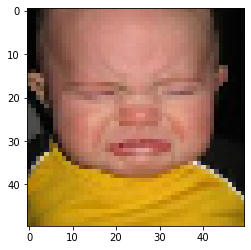

In [18]:
idx = 5
plt.imshow((X_train_color[idx]-X_train_color[idx].min())/(X_train_color[idx].max()-X_train_color[idx].min()))
plt.grid(False)

In [19]:
# connect new layers to the output
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = x_train_up[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time preds = res_no_top.predict(x)
preds.shape

Wall time: 1.41 s


(1, 2, 2, 2048)

In [20]:
x_train_up = preprocess_input(x_train_up)
x_test_up = preprocess_input(x_test_up)

In [25]:
%%time

# train on half the data, to save a few hours
x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)

Wall time: 3min 43s


In [26]:
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2, 2, 2048)]      0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               1638600   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 1,639,404
Trainable params: 1,639,404
Non-trainable params: 0
_________________________________________________________________


In [27]:
y_train_ohe_resnet = y_train_ohe_c[:x_train_resnet.shape[0]]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe_c[:x_test_resnet.shape[0]]))

Epoch 1/5
200/200 [==============================] - 8s 37ms/step - loss: 2.8293 - accuracy: 0.2567 - val_loss: 1.3765 - val_accuracy: 0.2728
Epoch 2/5
200/200 [==============================] - 7s 35ms/step - loss: 1.3962 - accuracy: 0.2745 - val_loss: 1.3798 - val_accuracy: 0.2775
Epoch 3/5
200/200 [==============================] - 7s 35ms/step - loss: 1.3841 - accuracy: 0.2660 - val_loss: 1.3829 - val_accuracy: 0.2612
Epoch 4/5
200/200 [==============================] - 7s 37ms/step - loss: 1.3828 - accuracy: 0.2767 - val_loss: 1.3774 - val_accuracy: 0.2941
Epoch 5/5
200/200 [==============================] - 8s 40ms/step - loss: 1.3772 - accuracy: 0.2847 - val_loss: 1.3719 - val_accuracy: 0.2988


In [28]:
model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe_c[:x_test_resnet.shape[0]]))

Epoch 1/5
200/200 [==============================] - 11s 53ms/step - loss: 1.3751 - accuracy: 0.2873 - val_loss: 1.3698 - val_accuracy: 0.3031
Epoch 2/5
200/200 [==============================] - 11s 55ms/step - loss: 1.3719 - accuracy: 0.2952 - val_loss: 1.3664 - val_accuracy: 0.3069
Epoch 3/5
200/200 [==============================] - 9s 44ms/step - loss: 1.3693 - accuracy: 0.3000 - val_loss: 1.3724 - val_accuracy: 0.3028
Epoch 4/5
200/200 [==============================] - 8s 39ms/step - loss: 1.3674 - accuracy: 0.3005 - val_loss: 1.3798 - val_accuracy: 0.2841
Epoch 5/5
200/200 [==============================] - 8s 38ms/step - loss: 1.3651 - accuracy: 0.3063 - val_loss: 1.3600 - val_accuracy: 0.3113


In [30]:
from tensorflow.keras.callbacks import EarlyStopping
transferHistory = model.fit(x_train_resnet,y_train_ohe_resnet,epochs=50,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe_c[:x_test_resnet.shape[0]]),
         callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Epoch 1/50
200/200 [==============================] - 8s 41ms/step - loss: 1.3587 - accuracy: 0.3185 - val_loss: 1.3606 - val_accuracy: 0.3066
Epoch 2/50
200/200 [==============================] - 9s 43ms/step - loss: 1.3571 - accuracy: 0.3113 - val_loss: 1.3511 - val_accuracy: 0.3178
Epoch 3/50
200/200 [==============================] - 10s 48ms/step - loss: 1.3561 - accuracy: 0.3186 - val_loss: 1.3578 - val_accuracy: 0.3197
Epoch 4/50
200/200 [==============================] - 9s 46ms/step - loss: 1.3549 - accuracy: 0.3143 - val_loss: 1.3535 - val_accuracy: 0.3169
Epoch 5/50
200/200 [==============================] - 8s 42ms/step - loss: 1.3525 - accuracy: 0.3198 - val_loss: 1.3472 - val_accuracy: 0.3278
Epoch 6/50
200/200 [==============================] - 8s 40ms/step - loss: 1.3520 - accuracy: 0.3202 - val_loss: 1.3477 - val_accuracy: 0.3169
Epoch 7/50
200/200 [==============================] - 7s 37ms/step - loss: 1.3490 - accuracy: 0.3229 - val_loss: 1.3422 - val_accuracy: 0.321

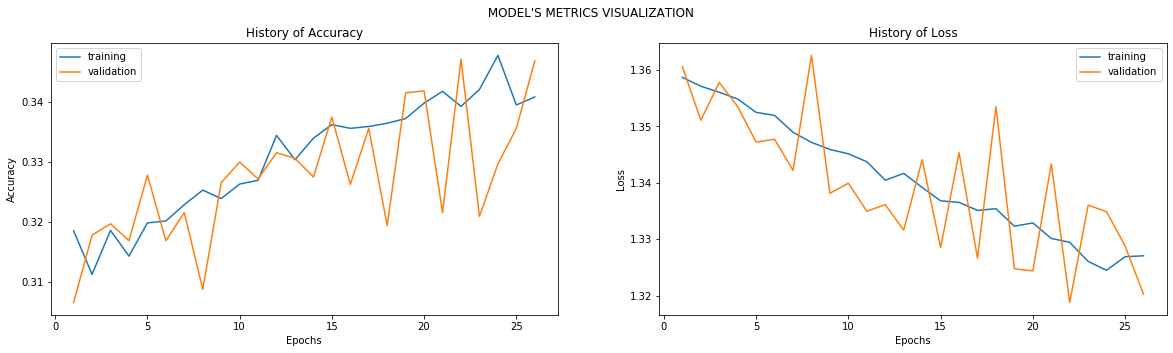

In [32]:
Train_Val_Plot(transferHistory.history['accuracy'],transferHistory.history['val_accuracy'],
               transferHistory.history['loss'],transferHistory.history['val_loss'],
              )

Early stopping cut that model short, but it appears that is trending in the right direction so going to give it another run below

In [33]:
transferHistory = model.fit(x_train_resnet,y_train_ohe_resnet,epochs=50,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe_c[:x_test_resnet.shape[0]]),
         callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Epoch 1/50
200/200 [==============================] - 9s 44ms/step - loss: 1.3244 - accuracy: 0.3424 - val_loss: 1.3209 - val_accuracy: 0.3481
Epoch 2/50
200/200 [==============================] - 9s 44ms/step - loss: 1.3217 - accuracy: 0.3402 - val_loss: 1.3284 - val_accuracy: 0.3406
Epoch 3/50
200/200 [==============================] - 9s 44ms/step - loss: 1.3213 - accuracy: 0.3437 - val_loss: 1.3186 - val_accuracy: 0.3478
Epoch 4/50
200/200 [==============================] - 9s 46ms/step - loss: 1.3200 - accuracy: 0.3411 - val_loss: 1.3235 - val_accuracy: 0.3322
Epoch 5/50
200/200 [==============================] - 8s 39ms/step - loss: 1.3191 - accuracy: 0.3458 - val_loss: 1.3153 - val_accuracy: 0.3484
Epoch 6/50
200/200 [==============================] - 7s 37ms/step - loss: 1.3186 - accuracy: 0.3449 - val_loss: 1.3324 - val_accuracy: 0.3241
Epoch 7/50
200/200 [==============================] - 8s 38ms/step - loss: 1.3186 - accuracy: 0.3439 - val_loss: 1.3236 - val_accuracy: 0.3266

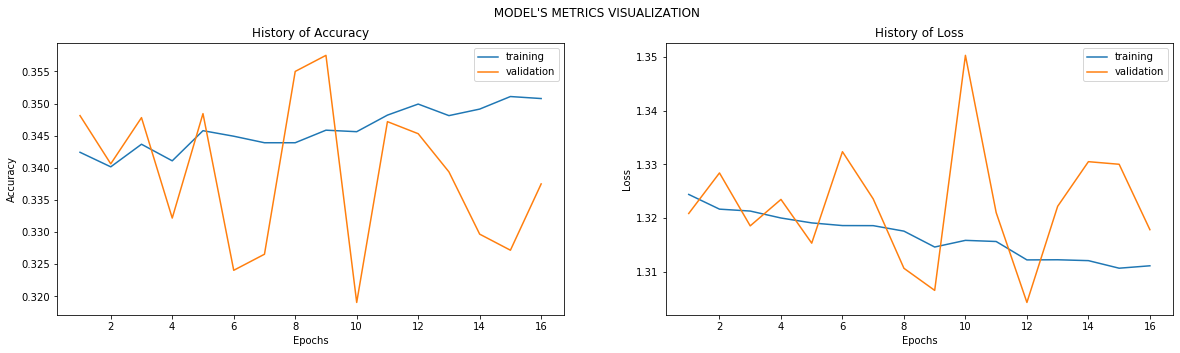

In [34]:
Train_Val_Plot(transferHistory.history['accuracy'],transferHistory.history['val_accuracy'],
               transferHistory.history['loss'],transferHistory.history['val_loss'],
              )

So it does appear that around 33% is the area of convergence for the Transfer Learning model. In comparison to our best CNN, the model Xception 2 performs much better than this Transfer Learning model with an accuracy of 64% (31% better, nearly doubling the accuracy of the Transfer Learning model!)

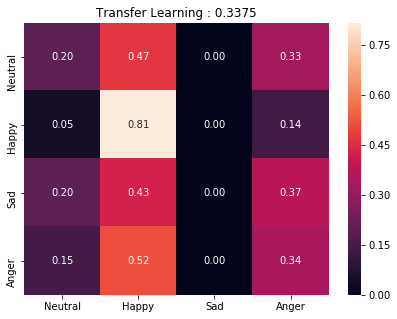

In [43]:
compare_mlp_cnn(None,model,x_test_resnet,y_test_color, 'Blank', 'Transfer Learning', newTypes)


Interesting...the Transfer Learning model does not appear to predict the emotion Sad at all

In [36]:
xception2 = keras.models.load_model("xception2_model/xception2_model")

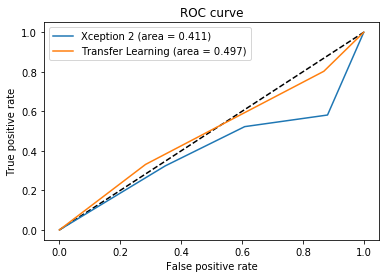

In [37]:
yhat_cnn = np.argmax(xception2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(model.predict_generator(x_test_resnet), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_color, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception 2 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='Transfer Learning (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [38]:
import scipy
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected =  scipy.stats.chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.765050  0.234950
True   0.601297  0.398703
statistic=1.615, p-value=0.2
Same proportions of errors (don't reject H0)
